In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#출력 그림 크기 조절
sns.set(rc={'figure.figsize':(12,12)})
plt.style.use('ggplot')
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

# for "5. Modeling with CatBoostRegressor"
from catboost import CatBoostRegressor
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold

In [2]:
# 데이터 로드
train = pd.read_csv('data/train0730.csv',index_col= False)
test = pd.read_csv('data/test0730.csv',index_col= False)

In [3]:
train = train.set_index("단지코드")
test = test.set_index("단지코드")

In [4]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

In [5]:
scailing_features = ['총세대수',
                     '지역',
                     '공가수',
                     '지하철',
                     '버스',
                     '단지내주차면수',
                     '총임대가구수',
                     '단지임대보증금',
                     '단지임대료'
                    ]

scaler = RobustScaler()
train.loc[:, scailing_features] = scaler.fit_transform(train[scailing_features])
test.loc[:, scailing_features] = scaler.transform(test[scailing_features])

In [4]:
train

,등록차량수,총세대수,지역,공가수,지하철,버스,단지내주차면수,총임대가구수,단지임대보증금,단지임대료,...,공급_공공분양,공급_공공임대(10년),공급_공공임대(50년),공급_공공임대(5년),공급_공공임대(분납),공급_국민임대,공급_영구임대,공급_임대상가,공급_장기전세,공급_행복주택
단지코드,,,,,,,,,,,,,,,,,,,,,
C2515,205.0,545.0,2,17.0,0.0,3.0,624.0,545.0,1.403597e+07,119431.266055,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1407,1064.0,1216.0,6,13.0,1.0,1.0,1285.0,1216.0,2.760498e+07,171132.236842,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1945,730.0,755.0,1,6.0,1.0,3.0,734.0,755.0,2.244915e+07,187414.211921,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1470,553.0,696.0,12,14.0,0.0,2.0,645.0,696.0,1.939399e+07,125449.224138,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1898,415.0,566.0,12,9.0,0.0,6.0,517.0,566.0,1.757307e+07,119608.038869,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2586,57.0,90.0,13,7.0,0.0,3.0,66.0,90.0,2.877333e+07,122286.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C2035,246.0,492.0,0,24.0,0.0,1.0,521.0,492.0,1.820122e+07,167341.463415,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C2020,19.0,40.0,7,7.0,1.0,2.0,25.0,40.0,2.690000e+07,130016.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Modeling with Gradient Boosting Regressor

- Setting Data For Model

In [7]:
X = train.drop(columns = ['등록차량수'])
y = train['등록차량수']

- Hyper params Tuning

In [8]:
def objective(trial: Trial) -> float:
    params_cat = {
        "random_state": 42,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "verbose" : 1,
        "objective" : "MAE",
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2)

    model = CatBoostRegressor(**params_cat)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False,
    )

    cat_pred = model.predict(X_val)
    log_score = mean_absolute_error(y_val, cat_pred)
    
    return log_score

In [9]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="cat_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=15)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-07-30 13:42:17,185] A new study created in memory with name: cat_opt
[I 2021-07-30 13:42:17,569] Trial 0 finished with value: 125.93285643770116 and parameters: {'max_depth': 6, 'colsample_bylevel': 0.9901428612819833, 'subsample': 0.8123957592679836, 'min_child_samples': 62, 'max_bin': 246}. Best is trial 0 with value: 125.93285643770116.
[I 2021-07-30 13:42:17,739] Trial 1 finished with value: 126.05888502939594 and parameters: {'max_depth': 3, 'colsample_bylevel': 0.8116167224336399, 'subsample': 0.9063233020424546, 'min_child_samples': 62, 'max_bin': 413}. Best is trial 0 with value: 125.93285643770116.
[I 2021-07-30 13:42:17,836] Trial 2 finished with value: 129.77507422443097 and parameters: {'max_depth': 1, 'colsample_bylevel': 0.9939819704323989, 'subsample': 0.8827098485602951, 'min_child_samples': 25, 'max_bin': 254}. Best is trial 0 with value: 125.93285643770116.
[I 2021-07-30 13:42:18,014] Trial 3 finished with value: 112.29710481692761 and parameters: {'max_depth'

Best Score: 112.29710481692761
Best trial: {'max_depth': 3, 'colsample_bylevel': 0.8608484485919076, 'subsample': 0.6673295021425665, 'min_child_samples': 46, 'max_bin': 287}


In [10]:
cat_p = study.best_trial.params
cat = CatBoostRegressor(**cat_p)

- StratifiedK-Fold for Regression

In [11]:
y_cat = pd.cut(y, 10, labels=range(10))
skf = StratifiedKFold(7)

preds = []
for tr_id, val_id in skf.split(X, y_cat) : 

    X_tr = X.iloc[tr_id]
    y_tr = y.iloc[tr_id]
    
    cat.fit(X_tr, y_tr, verbose = 0)
    
    pred = cat.predict(test)
    preds.append(pred)
cat_pred = np.mean(preds, axis = 0)

In [12]:
sample = pd.read_csv('data/sample_submission.csv')
sample['num'] = cat_pred
sample

,code,num
0,C1072,783.869682
1,C1128,1199.905868
2,C1456,521.416487
3,C1840,491.336308
4,C1332,1177.314806
...,...,...
145,C2456,228.096468
146,C1266,445.240749
147,C2152,7.559918
148,C1267,381.758953


In [13]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

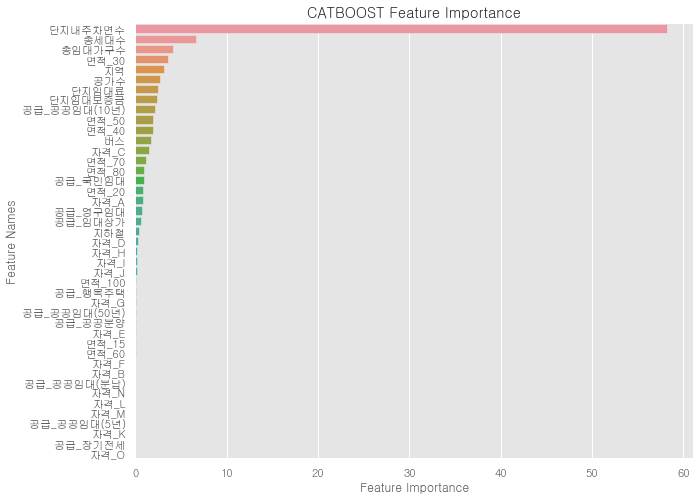

In [14]:
plot_feature_importance(cat.get_feature_importance(),test.columns,'CATBOOST')

In [15]:
sample.to_csv('sub/final_0730_4.csv', index=False)

In [16]:
sample

,code,num
0,C1072,783.869682
1,C1128,1199.905868
2,C1456,521.416487
3,C1840,491.336308
4,C1332,1177.314806
...,...,...
145,C2456,228.096468
146,C1266,445.240749
147,C2152,7.559918
148,C1267,381.758953
